In [11]:
%matplotlib inline
from netCDF4 import Dataset
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import os, glob
import matplotlib.ticker as ticker
plt.rcParams.update({'font.size':  15})
from matplotlib.patches import Circle
from PIL import Image


# Add Circle to images

In [19]:
lon_center, lat_center = -57.717,13.3
lon_pt_circle, lat_pt_circle = -57.245,14.1903
r_circle = np.sqrt((lon_pt_circle-lon_center)**2+(lat_pt_circle-lat_center)**2)
path_dir = "../output/TERRA_Modis"
lonmin,lonmax = -60,-55
latmin,latmax = 11.5,15
# Image box
dlon = lonmin-lonmax
dlat = latmin-latmax
width = 10
height = int(width*dlat/dlon)

In [20]:
for file in glob.glob(path_dir + "/*.jpg"):
    
    image = Image.open(file)
    fig = plt.figure()
    fig.set_size_inches(width, height, True)
    fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
    ax = fig.gca()
    im = ax.imshow(image,aspect=1)
    im.set_extent([lonmin,lonmax,latmin,latmax])

    # add HALO circle
    circ = Circle((lon_center,lat_center),r_circle,linewidth=3,ec="w",fill=False)
    ax.add_patch(circ)
    
        # remove axes
    ax.xaxis.set_ticklabels([])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticklabels([])
    ax.yaxis.set_ticks_position('none')
    
    fig.savefig("../output/TERRA_Modis/With_Circle/" + os.path.split(file)[-1])
    plt.close()

# Print GOES images in true colors

In [2]:
def calculate_true_colors(lon_min, lon_max, lat_min, lat_max, date, time):
    
    # Define some constants needed for the conversion. From the pdf linked above
    Esun_Ch_01 = 726.721072
    Esun_Ch_02 = 663.274497
    Esun_Ch_03 = 441.868715
    d2 = 0.3
    
    path_dir = "/run/media/ludo/DATA/google-drive/Thèse/EUREC4a/github/Input/Satellites/"
    name_01 = "GOES16_01_"+str(lat_min)+"N-"+str(lat_max)+"N_"+str(lon_min)+\
    "E-" + str(lon_max) + "E_" + str(date) + "_" + str(time) +".nc"
    path_01 = os.path.join(path_dir,str(date), "channel_1", name_01)
    name_02 = "GOES16_02_"+str(lat_min)+"N-"+str(lat_max)+"N_"+str(lon_min)+\
    "E-" + str(lon_max) + "E_" + str(date) + "_" + str(time) +".nc"
    path_02 = os.path.join(path_dir, str(date), "channel_2", name_02)
    name_03 = "GOES16_03_"+str(lat_min)+"N-"+str(lat_max)+"N_"+str(lon_min)+\
    "E-" + str(lon_max) + "E_" + str(date) + "_" + str(time) +".nc"
    path_03 = os.path.join(path_dir, str(date), "channel_3", name_03)
    
    channel_1 = xr.open_dataset(path_01).isel(time=0)
    channel_2 = xr.open_dataset(path_02).isel(time=0)
    channel_3 = xr.open_dataset(path_03).isel(time=0)
    
    lon=channel_1["lon"]
    lat=channel_1["lat"]
    
    channel_1["Reflectance"] = (channel_1["C01"] * np.pi * d2)/Esun_Ch_01
    channel_2["Reflectance"] = (channel_2["C02"] * np.pi * d2)/Esun_Ch_02
    channel_3["Reflectance"] = (channel_3["C03"] * np.pi * d2)/Esun_Ch_03
    
    R = channel_2["Reflectance"].clip(0,1)
    G = channel_3["Reflectance"].clip(0,1)
    B = channel_1["Reflectance"].clip(0,1)
    
    # Apply a gamma correction to the image to correct ABI detector brightness
    gamma = 6
    R = R**(1/gamma)
    G = G**(1/gamma)
    B =B**(1/gamma)

    # Calculate the "True" Green
    # Derived from Planet Labs data, CC > 0.9
    G_true = 0.48358168 * R + 0.06038137* G + 0.45706946*B
    G_true = G_true.clip(0,1)
    
    # The RGB array for the true color image
    RGB = np.dstack([R.values, G_true.values, B.values])

    return RGB, lat, lon
    

In [11]:
def plot_true_colors(lon_min, lon_max, lat_min, lat_max, list_date, list_time, list_type):
    
    list_RGB = []
    
    i=0
    for time in list_time:
        date = list_date[i]
        RGB, lat, lon = calculate_true_colors(lon_min, lon_max, lat_min, lat_max, date, time)
        list_RGB.append(RGB)
        i += 1
    
    i_max=2
    j_max=2
    
    fig, ax = plt.subplots(i_max, j_max, figsize=(20, 10))
   # fig.subplots_adjust(wspace=None, hspace=None)

    #fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)

    
    k = 0
    for i in range(0,i_max):
        for j in range(0, j_max):
            
            im = ax[i,j].imshow(list_RGB[k], aspect=1)
            im.set_extent([lon_min,lon_max,lat_min,lat_max])
            # add grid
            ax[i,j].xaxis.set_major_locator(ticker.MultipleLocator(1))
            ax[i,j].yaxis.set_major_locator(ticker.MultipleLocator(1))
            ax[i,j].grid(color='w', linestyle='-', linewidth=0.1, alpha=0.5)
            ax[i,j].xaxis.set_ticks_position('none')
            ax[i,j].yaxis.set_ticks_position('none')
            ax[i,j].set_title(str(list_date[k]) + " - " + str(list_time[k]) + " UTC - " + str(list_type[k]),\
                                  fontweight='bold',\
                                  loc='center')
            k+=1
            
    for i in range(0,i_max-1):
        for j in range(0, j_max):
              ax[i,j].xaxis.set_ticklabels([])
                
    for i in range(0,i_max):
        for j in range(1, j_max):
              ax[i,j].yaxis.set_ticklabels([])    
    
    for i in range(0, i_max):
        ax[i,0].set_ylabel('latitude')
    
    for j in range(0, j_max):
        ax[i_max-1, j].set_xlabel('longitude')
                        
    fig.savefig("Figures/GOES_4_types.jpeg")

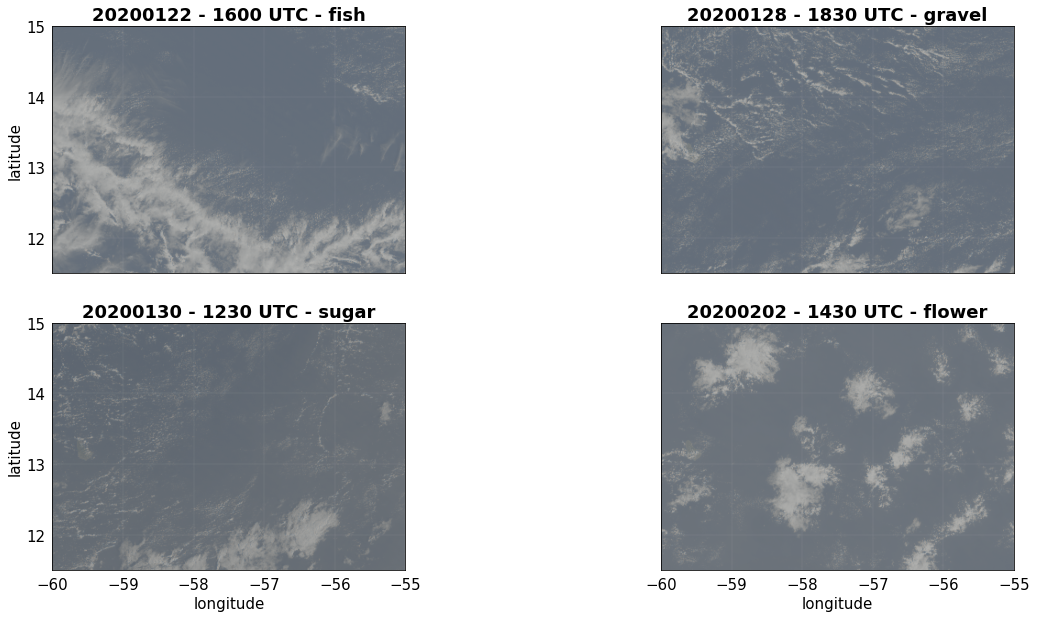

In [12]:
lon_min=-60
lon_max=-55
lat_min=11.5
lat_max=15
list_date = [20200122, 20200128, 20200130, 20200202]
list_time = [1600, 1830,1230,1430]
list_type = ["fish","gravel","sugar","flower"]
plot_true_colors(lon_min, lon_max, lat_min, lat_max, list_date, list_time, list_type)